# Policy Gradient

Bu Notebook Lunar Lander Continuous'un REINFORCE algoritmasi ile cozumunu icerir.

In [1]:
# Import Stuff
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
from tqdm import tqdm
from autograd.scipy.stats import multivariate_normal
from autograd import grad

%matplotlib inline

CSS = """
.output {
    align-items: center;
}
"""

display.HTML('<style>{}</style>'.format(CSS))

def show_state(env, e, t):
    plt.figure(3, figsize=(10, 10))
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Episode: {}, Step: {}".format(e, t))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

n_episodes = 1000
gamma = 0.9
alpha = 1.0
std = 0.33

# Lunar Lander

Ay yuzeyine inis yapan bir roketin size ihtiyaci var! Rokette 3 adet motor bulunmaktadir: Ana, sag ve sol. Roket asagiya dogru serbest dusus yaparken, motorlarini kullanarak kendini inis alanina indirmesi gerekmektedir. Eger roket yavas inis yaparsa +100, cakilirsa -100 odulu almaktadir. Eger inis alanina inmeyi basarirsa, ek olarak yaklasik 40 puan almaktadir. Roketin yan bir bicimde inis yapmasi da mumkundur fakat yere degen her ayak icin ekstra 10 puan alacaktir.  

Bu Notebook'da bu problemin surekli (continuous) versionu ele alinmistir. Aksiyon uzayi iki boyutludur. Ilk boyut ana motoru kontrol eder, ikinci boyut isi sag ile sol motoru. Bu degerler -1, +1 araligindadir. Ana motor icin, -1,0 arasi degerler motorun kapali olmasi demektir. Diger aksiyon degeri -1,-0.5 araliginda sol motoru; 0.5,1 araliginda sag motoru kontrol eder. Motoru ateslemek -0.3 puandir.  

Bu problemi surekli aksiyon degerleri icin cozebilmemiz icin policemizi Gaussian olarak modellememiz gerekmektedir. Policeyi guncelleyebilmek icin Gaussianin ortalama degerini $W$ ile parametrize ediyoruz. Kovaryanslari da parametrize edebiliriz fakat bu Notebook'da sabit kovaryans kullanip, iterasyonlar ilerledikce kovaryans genisliklerini daratma yontemi secildi.

$$
\pi(a|s) = \frac{1}{\sqrt{(2\pi)^{n}|\Sigma|}}exp(-\frac{1}{2}(a -\mu_W(s))^T\Sigma^{-1}(a -\mu_W(s)))
$$

REINFORCE algoritmasi ile $W$ degerlerini guncelleyecegiz. REINFORCE her iterasyonun sonundaki beklenen odullere gore guncellenmektedir ($G_t$). $G_t$ $t$'den sonraki odullerin toplamidir.

$$
G_t = \sum_{k=t}^{T}\gamma^{t}r_t
$$

$$
W \leftarrow W + \alpha \nabla_W\log{\pi(a_t|s_t)} G_t
$$

Bu Notebook'da gradyan hesaplamalari icin Python'in ``autograd`` kutuphanesi kullanildi.

In [2]:
# Parametrize edilmis ortalama
def mean(W, s):
    return np.matmul(W, s)

# Gaussian police eger greedy ise gaussian'dan aksiyon sec, degilse ortalamayi kullan
def policy(W, s, greedy):
    cov = np.eye(2) * std
    m = mean(W, s)
        
    if greedy:
        return m
    
    return np.random.multivariate_normal(m, cov)

def logpr(W, s, a):
    cov = np.eye(2) * std
    m = mean(W, s)
    
    return multivariate_normal.logpdf(a, m, cov)

dlogpr = grad(logpr)

# Greedy police kullanan fonksiyon
def run_env(env, W):
    state = env.reset()
    done = False
    t = 0

    while not done:
        t += 1
        show_state(env, 1, t)

        action = policy(W, state, True)
        next_state, reward, done, info = env.step(action)
        state = next_state

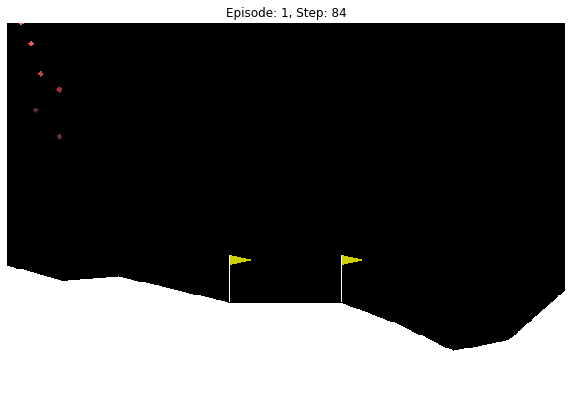

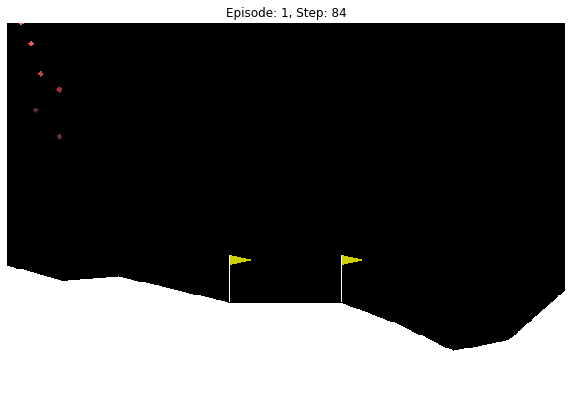

In [3]:
# Egitilmemis
W_rand = np.random.randn(2, 8)

env = gym.make('LunarLanderContinuous-v2')
run_env(env, W_rand)

In [4]:
# Parametreleri olusturalim
W = np.random.randn(2, 8)

rewards = []

# Her episode icin
for e in tqdm(range(1, n_episodes+1)):
    state = env.reset()
    done = False
    t = 0
    total_reward = 0
    trajectory = []
    
    # Bitmedigi surece
    while not done:
        # Gaussian policesinden aksiyon sec
        action = policy(W, state, False)
        # Aksiyonu uygula
        next_state, reward, done, info = env.step(action)
        # Tarihe kaydet
        trajectory.append((state, action, reward))
        total_reward += reward
        state = next_state
        
        t += 1
       
    rewards.append(total_reward)
    
    # Bu episodda alinmis her aksiyon icin
    for t, (s, a, r) in enumerate(trajectory[:-1]):
        # Beklenen odullerin toplami
        G = np.sum([gamma**(t+i) * trj[2] for i, trj in enumerate(trajectory[t:])])
        # Gradyan
        dW = dlogpr(W, s, a)
        # REINFORCE
        W += alpha * dW * G
    
    # std degiskeni giderek aziltiliyor ki ilerledikce daha az kesif yapilsin
    if e % 100 == 0:
        std /= 2

env.close()

100%|██████████| 1000/1000 [04:30<00:00,  3.52it/s]


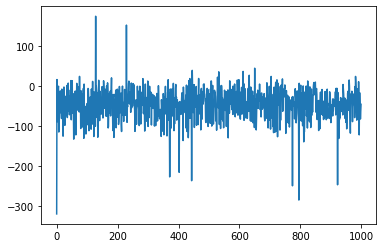

In [5]:
plt.plot(rewards)

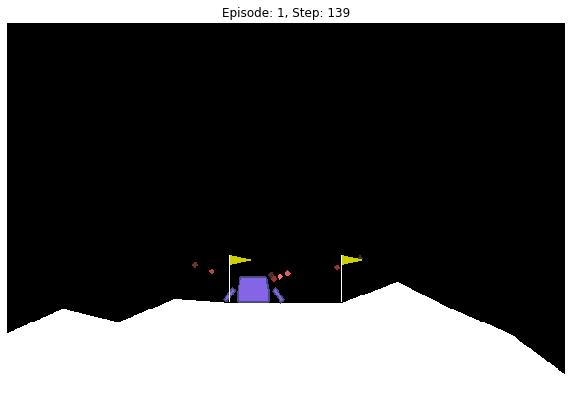

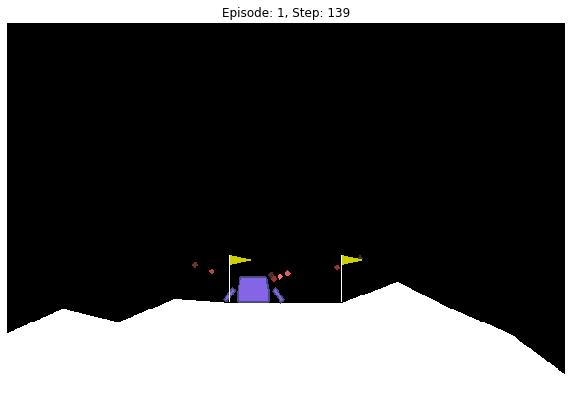

In [6]:
# Egitildikten sonra
run_env(env, W)

# Sonuc

In [7]:
W1 = np.array([[-2.37494525e+81,  3.62110635e+80,  2.40669593e+82, -1.20541133e+82,
  -7.57000428e+82, -7.49175990e+82,  1.11027891e+74,  1.44057090e+00]
 [ 5.06799976e+81 -7.72723755e+80 -5.13575392e+82  2.57228006e+82
   1.61539639e+83  1.59869948e+83 -2.36927283e+74  1.18120810e+00]])

[[-2.37494525e+81  3.62110635e+80  2.40669593e+82 -1.20541133e+82
  -7.57000428e+82 -7.49175990e+82  1.11027891e+74  1.44057090e+00]
 [ 5.06799976e+81 -7.72723755e+80 -5.13575392e+82  2.57228006e+82
   1.61539639e+83  1.59869948e+83 -2.36927283e+74  1.18120810e+00]]
